In [1]:
import numpy as np
import torch
from discrete_network.network import KNNet, KNNetParameters, KNNetState
from discrete_network.method.force_method import ForceParameters, ForceLearn
from discrete_network.device import device
import matplotlib.pyplot as plt

print(f"Device = {device.type}")

Device = cuda


In [2]:
# params_spiking = KNNetParameters(eps = 0.015, beta = 0.0, d = 0.26, a = 0.25, J = 0.1081 + 0.1)
params_spiking = KNNetParameters(eps = 0.02, beta = 0.0, d = 0.26, a = 0.25, J = 0.1081 + 0.1)

def one_neuron(x0, y0, iteration, p: KNNetParameters):
    """The dynamics of one neuron. Return x, y."""
    x, y = np.zeros(iteration), np.zeros(iteration)
    x[0], y[0] = x0, y0
    for i in range(iteration - 1):
        x[i + 1] = (
            x[i]
            + x[i] * (x[i] - p.a) * (1 - x[i])
            - p.beta * (x[i] > p.d)
            - y[i]
        )
        y[i + 1] = y[i] + p.eps * (x[i] - p.J)
    return x, y

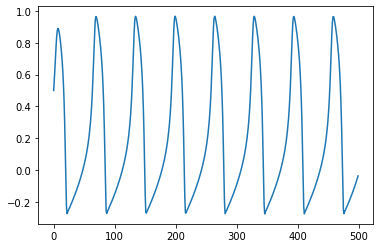

In [3]:
imin = 0; icrit = 20000; nt = 21000
f_out, _ = one_neuron(.5, 0, nt, params_spiking)
%matplotlib inline
plt.figure()
plt.plot(f_out[0:500])
plt.show()
plt.close()

In [4]:
f_out = f_out.reshape(f_out.shape[0], 1)
print(f_out.shape)

(21000, 1)


In [5]:
input_size = 0
hidden_size = 2000 # 4000 was best
output_size = 1
eps_m = 0.025
delta_eps = 0.005
a = 0.25
eps = -delta_eps + 2 * delta_eps * torch.rand(hidden_size, 1).to(device) + eps_m
#eps = torch.as_tensor(eps_m).to(device)
# J = (1 + a - torch.sqrt(1 + a * a - a + 3 * eps)) / 3 + 0.01 # Slightly more bifurcation value
J = (1 + a - torch.sqrt(1 + a * a - a + 3 * eps)) / 3 + 0.05
J = J.to(device)
p = KNNetParameters(eps=eps, J=J, q=0.5)


x_initial = 0.6 * torch.rand(hidden_size, 1).to(device)
y_initial = torch.zeros(hidden_size, 1).to(device)
z_initial = torch.zeros(hidden_size, 1).to(device)
ISPC_initial = torch.zeros(hidden_size, 1).to(device)
initial_state = KNNetState(x=x_initial, y=y_initial, z=z_initial, ISPC=ISPC_initial)
net = KNNet(input_size, hidden_size, output_size, p=p)
net.to_device(device)
lp = ForceParameters(stop_learning=icrit, start_learning=imin)
fl = ForceLearn(net=net, lp=lp, save_states=True)

In [6]:
f_out = f_out.reshape((f_out.shape[0], 1))
print(f"f_out.shape = {f_out.shape}")

f_out.shape = (21000, 1)


In [7]:
train_logs, states = fl.train(target_outputs=f_out, state=initial_state)

100%|██████████| 21000/21000 [00:26<00:00, 798.38it/s] 


In [8]:
# np.savetxt('train_logs', train_logs.numpy(), delimiter=' ')

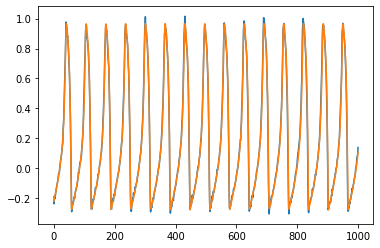

In [9]:
plt.plot(train_logs.numpy()[-1000:, 0, 0])

plt.plot(f_out[-1000:, 0])
plt.show()
plt.close()

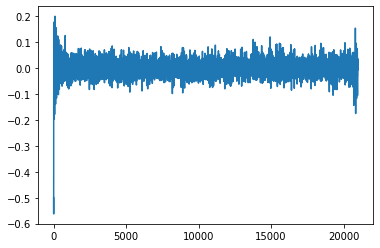

In [10]:
plt.plot((train_logs.numpy()[:, 0, 0] - f_out[:, 0]))


In [11]:

x = []
y = []
for i in range(len(states)):
    x.append(states[i].x)
    y.append(states[i].y)
x = torch.stack(x)
y = torch.stack(y)

x.shape

torch.Size([21000, 2000, 1])

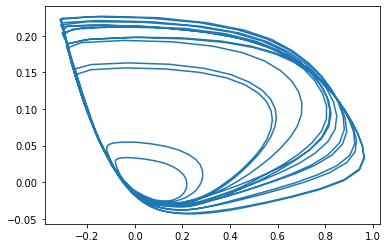

In [12]:
plt.plot(x.numpy()[-1000:, 5], y.numpy()[-1000:, 5])

In [13]:
from discrete_network.pca.pca import PCA
x = x.reshape(*x.shape[0:2])
y = y.reshape(*y.shape[0:2])

pca = PCA(3)

(torch.Size([1000, 3]), torch.Size([21000, 2000]), torch.Size([21000, 4000]))

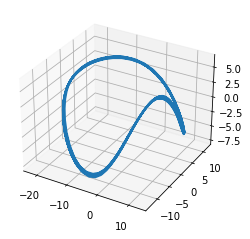

In [14]:
pca_x = pca.decompose(x[-1000:])

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
plt.plot(pca_x.numpy()[:, 0], pca_x.numpy()[:, 1], pca_x.numpy()[:, 2])
plt.show()
plt.close()

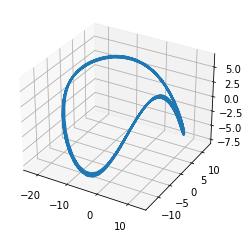

In [19]:
trajectory = torch.concat((x, y), axis=1)
pca_traj = pca.decompose(trajectory[-1000:])

fig2 = plt.figure()
ax2 = fig2.add_subplot(projection='3d')
plt.plot(pca_traj.numpy()[:, 0], pca_traj.numpy()[:, 1], pca_traj.numpy()[:, 2])
plt.show()
plt.close()

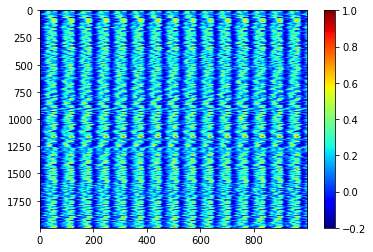

In [21]:
n_neuron = hidden_size
n_time = 400
x_np = x.numpy()

fig3 = plt.figure()
plt.imshow(x_np.T[:, -1000:], cmap='seismic', aspect='auto')
plt.colorbar()
plt.clim(-0.2, 1.0)
plt.show()
plt.close()

In [17]:
from operator import itemgetter
x_th = 0.65
data = x_np

# get time index (column) of first spike
first_spike_indexes = []
for i in range(data.shape[1]):
    first_spike_indexes.append(np.where(data[-1000:, i] > x_th)[0][0])

# sorted_indexes = ([x for _, x in sorted(zip(first_spike_indexes, [i for i in range(data.shape[1])]))])
x_dict = zip(list(range(data.shape[1])), first_spike_indexes)
x_dict = sorted(x_dict, key = itemgetter(1))
sorted_indexes, _ = zip(*x_dict)

data_sorted = np.zeros_like(data)
for i in range(data.shape[1]):
    data_sorted[:, i] = data[:, sorted_indexes[i]]
    
len(sorted_indexes) == len(set(sorted_indexes))

True

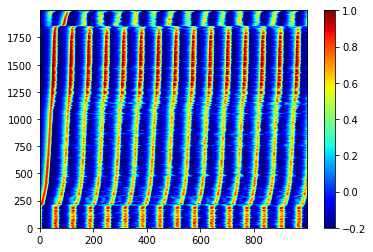

In [22]:
fig4 = plt.figure()
plt.imshow(data_sorted.T[:, -1000:], cmap='seismic', aspect='auto', origin='lower')
plt.colorbar()
plt.clim(-0.2, 1.0)
plt.show()
plt.close()

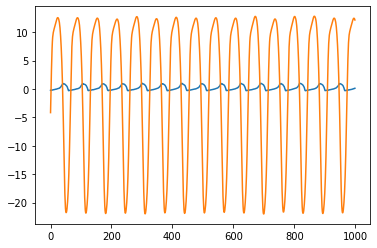

In [45]:
plt.plot(np.arange(1000), train_logs.numpy()[-1000:, 0, 0])
plt.plot(np.arange(1000), pca_x.numpy()[:, 0])
# plt.plot(x_np[-1000:, 5], x_np[-1000:, 5])
# plt.plot(pca_x.numpy()[:, 0], pca_x.numpy()[:, 1])
plt.show()
plt.close()